# Step 1: Introduction

I use the popular ToDoist application to track all of my open tasks. ToDoist has many strengths - e.x. a clean user interface, presence on every platform, and gamification features (ToDoist Karma). One of its main flaws, however, is the omission of useful tools that could be used to track productivity.

The purpose of this analysis is to use the ToDoist API to derive insights about how to improve my productivity. Some of the questions investigated are the following: 

- How many tasks were completed on a weekly basis?
- What is the breakdown of completed tasks by required energy level?
- Is there a correlation between number of total tasks completed and required energy level?
- How many professional project tasks contain the word 'meeting' or 'ship'? 

# Step 2: Data Wrangling

In [1]:
import pandas as pd
import numpy as np

import datetime
import pytz

import matplotlib.pyplot as plt
import seaborn as sns

## Import Table of Projects

In [2]:
projectTable = pd.read_csv('projectTable.csv', index_col = 0)
projectTable

,id,color,parent_id
Inbox,180416404,7,None
Personal,180416408,8,None
Weekly Habits,190555550,17,180416408
Bridge Year,187244722,12,180416408
Community Bucket,194942145,15,180416408
Family,189435039,19,None
SIEMENS,181003063,11,None
Shopping,180431991,9,None
Future Projects,182035396,8,None
Bucket List,2148533029,15,None


## Import Table of Items

In [3]:
itemTable = pd.read_csv('itemTable.csv', index_col = 0)
itemTable.head(10)

,Project_Id,Project,Item_Id,Content,Date,Energy,Time
0,190555550,None,2200735265,Do the laundry and fold clothes (if time allow...,Sun 31 Dec 2017 14:27:08 +0000,None,None
1,190555550,None,87202330,Conduct GTD weekly review according to templat...,Sun 31 Dec 2017 14:27:04 +0000,None,None
2,180416408,None,2453991536,Sort items for Keep and Donation in Jesse's ro...,Sun 31 Dec 2017 14:12:46 +0000,None,None
3,190555550,None,84028045,"Do some form of physical activity (run, lift, ...",Sun 31 Dec 2017 14:11:41 +0000,None,None
4,2165537638,None,2449385146,PlanningGraph.h_levelsum method @30-minutes @H...,Sat 30 Dec 2017 15:24:19 +0000,None,None
5,180416408,None,2453016179,Deliver cube storage unit to Shamika in Greenb...,Sat 30 Dec 2017 03:34:41 +0000,None,None
6,180416408,None,2453016018,Sort items from basement and closet into piles...,Sat 30 Dec 2017 03:34:07 +0000,None,None
7,2165537638,None,2449385064,PlanningGraph.inconsistent_support_mutex metho...,Sat 30 Dec 2017 01:47:32 +0000,None,None
8,2165537638,None,2449384974,PlanningGraph.negation_mutex method @Low-energ...,Sat 30 Dec 2017 01:36:38 +0000,None,None
9,2165537638,None,2449384886,PlanningGraph.competing_needs_mutex method @30...,Sat 30 Dec 2017 01:23:19 +0000,None,None


## Localize time from UTC to EST for each task

In [4]:
def localize_time(api_time, myTimeZone):
    """Convert timezone from UTC to local.
    Args:
        api_time: UTC time from ToDoist API.
        myTimeZone: Pytz object generated for local timezone.

    Returns:
        api_time: Modified for local timezone in datetime object format.
    """    
    api_time = datetime.datetime.strptime(api_time, "%a %d %b %Y %H:%M:%S %z")
    
    return api_time.astimezone(myTimeZone)

In [5]:
def parse_full_date(local_date):
    """Converts date from Todoist format to mm/dd/yyyy
    Args:
        local_date: Localized date and time in ToDoist format.

    Returns:
        local_date: Modified for mm/dd/yyyy format.
    """    
    return local_date.strftime('%m-%d-%Y')

In [6]:
# Convert completed time from UTC to EST
myTimeZone = pytz.timezone('US/Eastern')
itemTable["Date"] = itemTable["Date"].apply(localize_time, args=(myTimeZone,))

## Categorize energy levels for each task

In [7]:
def energy_level(content):
    """Categorizes task by energy label.
    Args:
        content: Complete task description from ToDoist.

    Returns:
        Appropriate energy label in string format.
    """
    if (content.find("@High-energy") != -1):
        return "High-energy"
    elif (content.find("@Normal-energy") != -1):
        return "Normal-energy"
    elif (content.find("@Low-energy") != -1):
        return "Low-energy"
    else:
        return None

In [8]:
# Strip local time to include date only
#itemTable["Date"] = itemTable["Date"].map(parse_full_date)

# Categorize energy labels
itemTable["Energy"] = itemTable["Content"].map(energy_level)

## Categorize the time required for each task

In [9]:
def time_effort(content):
    """Categorizes task by time label.
    Args:
        content: Complete task description from ToDoist.

    Returns:
        Appropriate time label in int format.
    """
    if (content.find("@60-minutes") != -1 ):
        return 60
    elif (content.find("@30-minutes") != -1):
        return 30
    elif (content.find("@5-minutes") != -1):
        return 5
    else:
        return None

In [10]:
# Categorize time labels
itemTable["Time"] = itemTable["Content"].map(time_effort)

## Link together the items and projects

In [11]:
def project_link(project_id):
    """Links project id with project name
    Args:
        project_id: Identifier for project in int format.

    Returns:
        Project name in string format.
    """
    try:
        return (str(projectTable.index[projectTable['id'] == project_id][0]))
    except:
        return ('Personal')

In [12]:
# Match project id with project name
itemTable["Project"] = itemTable["Project_Id"].map(project_link)

In [13]:
itemTable.iloc[0:30]

,Project_Id,Project,Item_Id,Content,Date,Energy,Time
0,190555550,Weekly Habits,2200735265,Do the laundry and fold clothes (if time allow...,2017-12-31 09:27:08-05:00,Normal-energy,60.0
1,190555550,Weekly Habits,87202330,Conduct GTD weekly review according to templat...,2017-12-31 09:27:04-05:00,Normal-energy,60.0
2,180416408,Personal,2453991536,Sort items for Keep and Donation in Jesse's ro...,2017-12-31 09:12:46-05:00,Low-energy,60.0
3,190555550,Weekly Habits,84028045,"Do some form of physical activity (run, lift, ...",2017-12-31 09:11:41-05:00,Normal-energy,60.0
4,2165537638,AIND-1,2449385146,PlanningGraph.h_levelsum method @30-minutes @H...,2017-12-30 10:24:19-05:00,High-energy,30.0
5,180416408,Personal,2453016179,Deliver cube storage unit to Shamika in Greenb...,2017-12-29 22:34:41-05:00,Low-energy,60.0
6,180416408,Personal,2453016018,Sort items from basement and closet into piles...,2017-12-29 22:34:07-05:00,High-energy,60.0
7,2165537638,AIND-1,2449385064,PlanningGraph.inconsistent_support_mutex metho...,2017-12-29 20:47:32-05:00,Low-energy,5.0
8,2165537638,AIND-1,2449384974,PlanningGraph.negation_mutex method @Low-energ...,2017-12-29 20:36:38-05:00,Low-energy,5.0
9,2165537638,AIND-1,2449384886,PlanningGraph.competing_needs_mutex method @30...,2017-12-29 20:23:19-05:00,Normal-energy,30.0


# Step 3: Data Analysis

## Total number of tasks completed this year

In [14]:
itemTable.shape[0]

1482

Wow! That's a lot tasks. This gives me a goal to work towards this year as well.

## Number of tasks completed each week

I am quite interested in investigating how many tasks I completed each week for the past year. In order to do this, I'll group the number of items completed each week (in the Item Table) and plot that information.

In [15]:
# Produces a Pandas groupby object with date, project as keys, and indices of relevant columns
gDateProject_all = itemTable.groupby([pd.Grouper(freq='1W', key='Date'),'Project'], as_index=True)

# Gives list of dictionary keys and indices of relevant columns
gDateProject_all.groups

# Gives count of items in grouped list (by dictionary key)
gDateProject_all.count()

# Gets slice of relevant column from grouped dataframe
gDateProject_content = gDateProject_all['Content']

# Gives count of items from sliced column
gDateProject_content = gDateProject_content.count()
#gDateProject_content

In [16]:
# Groups already grouped dataframe by parent index (level=0) AND sums it up
gDate_content_count = gDateProject_content.groupby(level=0)
gDate_content_count = gDate_content_count.sum()
# gDate_content_count

In [17]:
# Raw table showing all the tasks completed each week this year
gDate_vProject = gDateProject_content.unstack(level=1, fill_value=0)
# gDate_vProject

Populating the interactive namespace from numpy and matplotlib


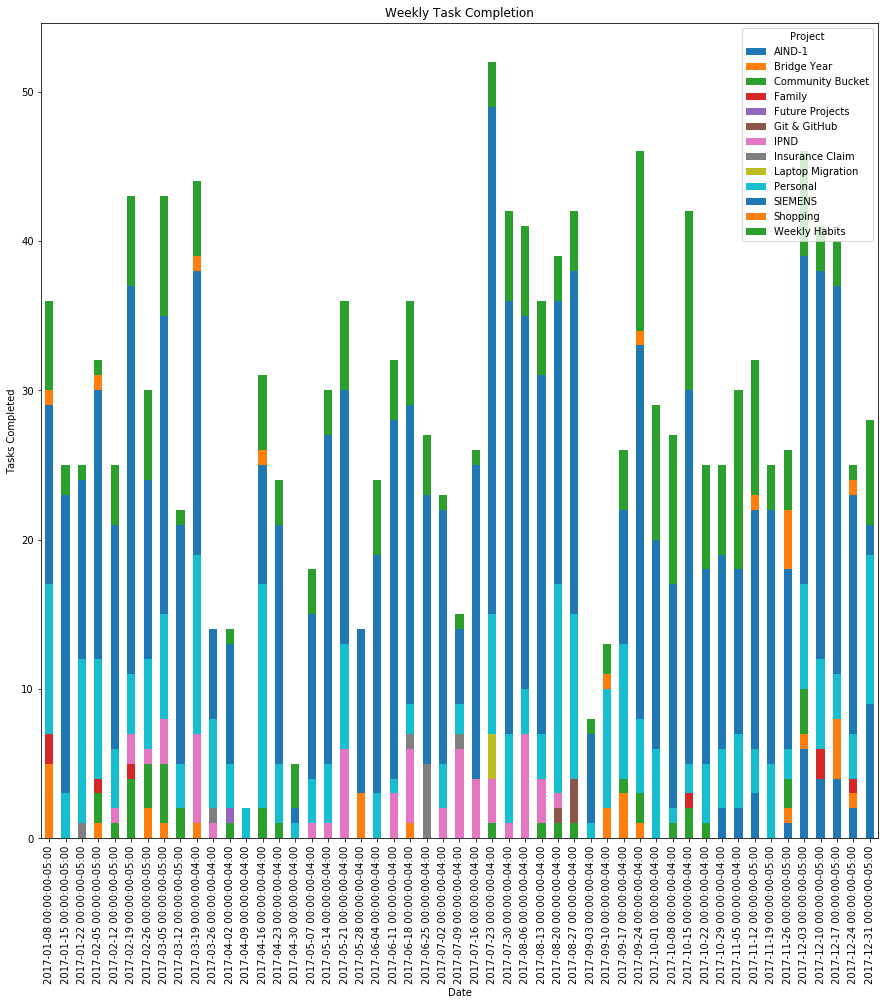

In [18]:
%pylab inline

stackTaskCompleted = gDate_vProject.plot.bar(stacked=True, figsize=(15, 15))
stackTaskCompleted.set_ylabel("Tasks Completed")
stackTaskCompleted.set_title("Weekly Task Completion")

It's interesting to note some of the peaks and valley's in the graph above (each x-axis label represents the date on which a week ends): 
- I was puzzled by low task completion numbers at the end of March and early April. Upon further reflection, I realized that during this time period I was in Europe with my parents (on vacation).
- There were a few weeks at the end of July and during August which were extremely fruitful. Unsurprising, since that month involved a sprint to complete my Intro to Programming Nanodegree, moving apartments, important work deadlines, and preparation for my trip to Japan.

This information is quite interesting, but I know that not all tasks are created equal. Completing a dizzying array of low-energy tasks (taking out the trash, buying tickets to a show, cancelling my Comcast subscription, etc) doesn't really help me achieve big, hairy goals.

# Relationship between energy level and overall task completion

In order to get a more accurate picture of productivity, I want to compare the number of high-energy tasks (which require deep work) agains the total number of tasks completed in each week. 

Below, I first graph the overall breakdown of tasks by energy type. Second, I compare the number of total tasks completed with the number of high energy tasks completed each week.

In [19]:
# Plot of tasks completed each week by energy level

gDateEnergy = itemTable.groupby([pd.Grouper(freq='1W', key='Date'),'Energy'], as_index=True)
gDateEnergy_content = gDateEnergy['Content']

# cust = itemTable.groupby(['Energy'], as_index=True)
# cust.get_group('Normal-energy')

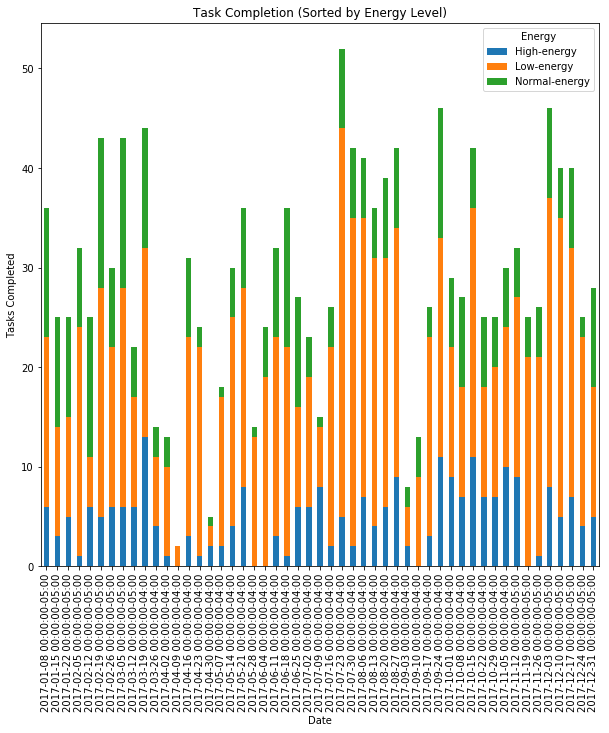

In [20]:
gDateEnergy_plot = gDateEnergy_content.count().unstack().plot.bar(stacked=True, figsize=(10, 10))
gDateEnergy_plot.set_title('Task Completion (Sorted by Energy Level)')
gDateEnergy_plot.set_ylabel("Tasks Completed")

In [21]:
# gDateEnergy_content.count()
gDate_vEnergy = gDateEnergy_content.count().unstack()
gDate_vEnergy = gDate_vEnergy.fillna(0)

In [22]:
gDate_vEnergy['Total'] = gDate_vEnergy.sum(axis=1)
gDate_vEnergy

Energy,High-energy,Low-energy,Normal-energy,Total
Date,,,,
2017-01-08 00:00:00-05:00,6.0,17.0,13.0,36.0
2017-01-15 00:00:00-05:00,3.0,11.0,11.0,25.0
2017-01-22 00:00:00-05:00,5.0,10.0,10.0,25.0
2017-02-05 00:00:00-05:00,1.0,23.0,8.0,32.0
2017-02-12 00:00:00-05:00,6.0,5.0,14.0,25.0
2017-02-19 00:00:00-05:00,5.0,23.0,15.0,43.0
2017-02-26 00:00:00-05:00,6.0,16.0,8.0,30.0
2017-03-05 00:00:00-05:00,6.0,22.0,15.0,43.0
2017-03-12 00:00:00-05:00,6.0,11.0,5.0,22.0


Correlation: 0.54


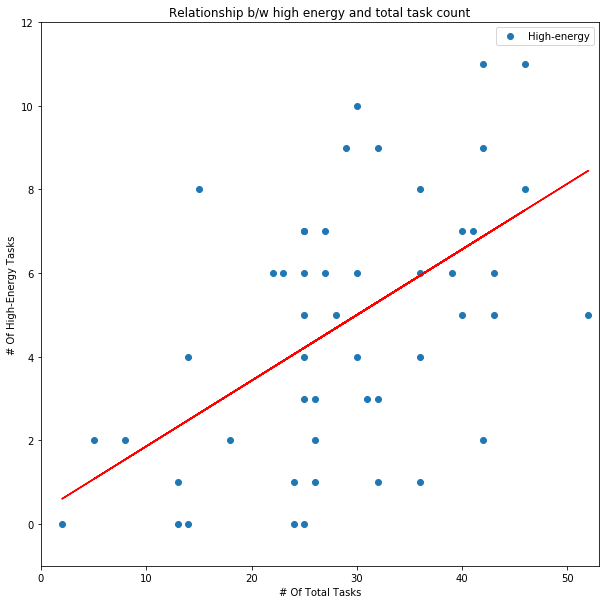

In [23]:
highEnergy_vTotal = gDate_vEnergy.plot(x='Total', y='High-energy', style='o', figsize=(10, 10))
highEnergy_vTotal.set_xlim([0,53])
highEnergy_vTotal.set_ylim([-1,12])
highEnergy_vTotal.set_title('Relationship b/w high energy and total task count')
highEnergy_vTotal.set_xlabel('# Of Total Tasks')
highEnergy_vTotal.set_ylabel('# Of High-Energy Tasks')

gDate_vEnergy_x = gDate_vEnergy['Total']
gDate_vEnergy_y = gDate_vEnergy['High-energy']

gDate_vEnergy_fit = np.polyfit(gDate_vEnergy_x, gDate_vEnergy_y, deg=1)
highEnergy_vTotal.plot(gDate_vEnergy_x, gDate_vEnergy_fit[0] * gDate_vEnergy_x + gDate_vEnergy_fit[1], color='red')

highEnergy_vTotal_corr = gDate_vEnergy['High-energy'].corr(gDate_vEnergy['Total'])
print ('Correlation: ' + str(round(highEnergy_vTotal_corr,2)))

# gDateEnergy_content.count().groupby(level=1).sum()

As shown by the plot, there is a positive correlation between the number of high-energy tasks and the total number of tasks completed each week. This result was quite surprising to me. My intuition suggested that I got a fewer total number of tasks completed on the weeks that I got a lot of high-energy tasks done (because they tend to take a longer amount of time). But as it turns out, getting high-energy tasks motivates me to get more done overall.

## Miscellaneous

One of my side responsibilites at work is to coordinate the receipt and shipment of prototype parts to other locations. I was curious to see how many shipments I had made (by filtering tasks by the word "ship").

In [24]:
ship_hash = itemTable['Content'].str.contains("ship")
print ("Total Shipments : " + str(ship_hash.sum()))

Total Shipments : 34


Wow! That's a lot of shipments. I'm going to discuss this with my manager to see whether we can hire someone to make shipments for us.

Next, I was interested to investigate how many meetings I had attended or hosted.

In [25]:
itemTable['Content'] = itemTable['Content'].str.lower()
meeting_hash = itemTable['Content'].str.contains("meeting")
print ("Total Meeting Count : " + str(meeting_hash.sum()))

Total Meeting Count : 332


In [26]:
totalMeetingTime = ((itemTable['Time'] * meeting_hash).sum()) / 60
print ("Total Meeting Time : " + str(round(totalMeetingTime)) + " " + "Hours")

Total Meeting Time : 230.0 Hours


Overall, I spent over a month in meetings (assuming 40hr work weeks) this year! Because of the nature of my work, it is unlikely that I will ever be able to get this close to zero. However, I wouldn't be surprised if I could reduce meeting time in half; I should also have a discussion with my manager on how to do this.

# Conclusion

This project was quite helpful in understanding some basic facts about my productivity history:

- Overall, I learned that the end of June and early August were my most productive months (when I had quite a few parallel projects due)
- There is a positive correlation between the number of high-level energy tasks completed and total tasks. Getting the hard tasks accomplished may motivate me to complete more of the easier tasks.
- I've spent a significant portion of my time (over 150+ hours) in meetings and making shipments. I need to have a discussion about these two topics with manager to see how we can reduce the amount of time spent on them.

Completing this analyis only leads to more questions, however. In a future revision to this project, I would be curious to explore the following:
- How did the number of meetings in a week affect the total number of high-energy tasks completed?
- Why exactly was I able to complete more high-energy tasks in certain weeks as opposed to others? Could the number of my social engagements with friends have had an impact?
- Was I able to complete high-energy tasks during the week or on the weekend?
